In [26]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay


Descripción del Dataset: El dataset de costos médicos personales contiene información sobre varios factores que afectan los costos de seguros médicos, como la edad, el sexo, el índice de masa corporal, y el hábito de fumar. Este dataset es ideal para practicar técnicas de preprocesamiento y optimización de modelos debido a la presencia de datos sucios y variables tanto categóricas como numéricas.

Columns

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance


1. Carga y Exploración Inicial de Datos:

* Cargar el dataset desde Kaggle.
* Realizar una exploración inicial para entender la estructura del dataset y las características disponibles.
* Identificar y documentar los valores faltantes y outliers en el dataset.



In [2]:
##Cargar los datos
ruta_archivo = '../ejercicios_core/data/insurance.csv'
df = utils.cargar_datos(ruta_archivo)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
##Exploracion incial
utils.exploracion_inicial(df)

Informacion del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
Estadisticas del dataset
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.0

##### Este dataset cuenta con 1338 filas y 7 columnas. En general, las variables muestran rangos amplios y cierta variabilidad, siendo los costos (charges) la más dispersa. Las distribuciones son generalmente simétricas, salvo en el caso de los costos, donde se observan valores extremos que podrían influir en los modelos predictivos.

In [4]:
na_df = utils.identificar_valores_faltantes(df)
print(na_df)
utils.verificacion_elementos_duplicados(df)
### Eliminar valores duplicados
df = df.drop_duplicates()

Valores faltantes en el dataset
          datos sin NAs en q  Na en q  Na en %
age                     1338        0      0.0
sex                     1338        0      0.0
bmi                     1338        0      0.0
children                1338        0      0.0
smoker                  1338        0      0.0
region                  1338        0      0.0
charges                 1338        0      0.0
Cantidad de filas duplicadas:  1


##### no se encuentran valores nulos pero si un duplicado que fue eliminado para no afectar el balance de la clases target

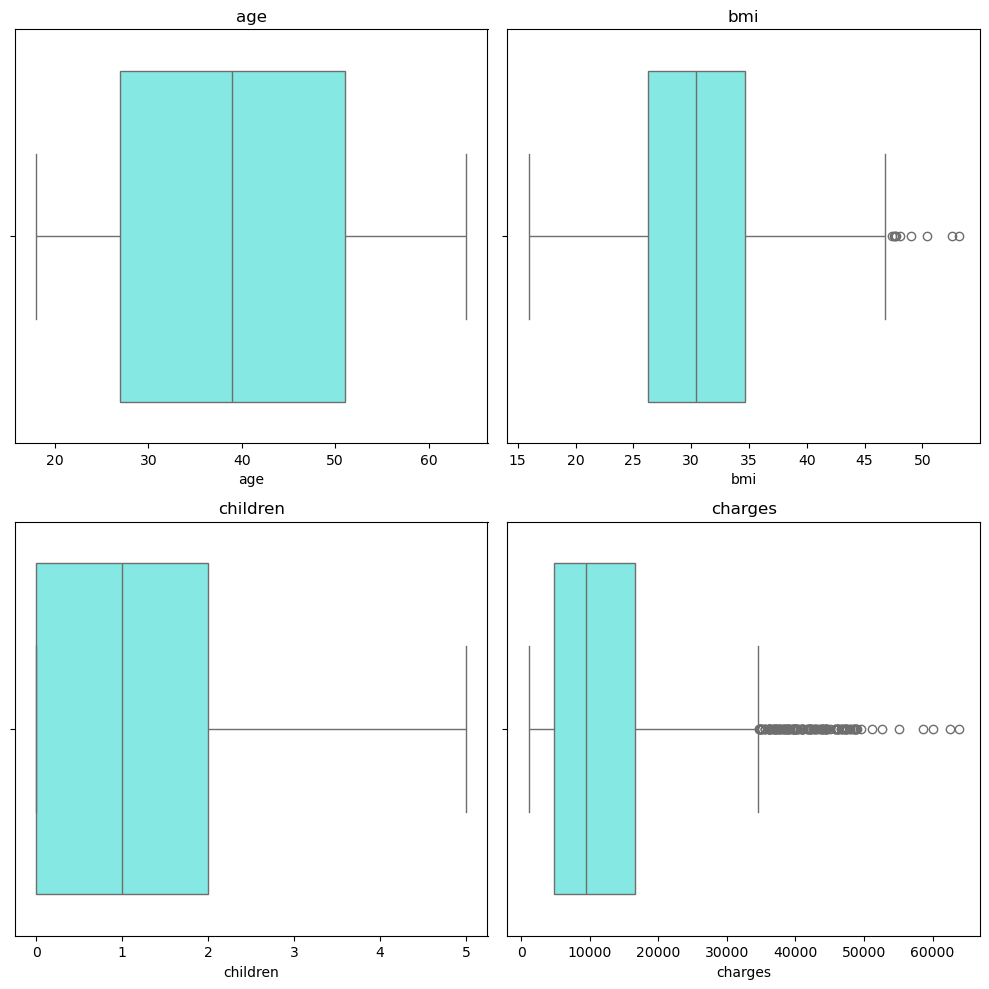

In [5]:
num_features = df.select_dtypes(include=['int64', 'float64'])
utils.plot_grafico_outliers(num_features,2,2,df)

##### Se verifica outliers en 2 variables de bmi y charges, sin embargo estos podria indicar que las personas con alto indice corporal podrian tener una relacion muy alta con el costo de su seguro medico, por lo que se supone mejor realizar un escalamiento para tratar estos outliers. 

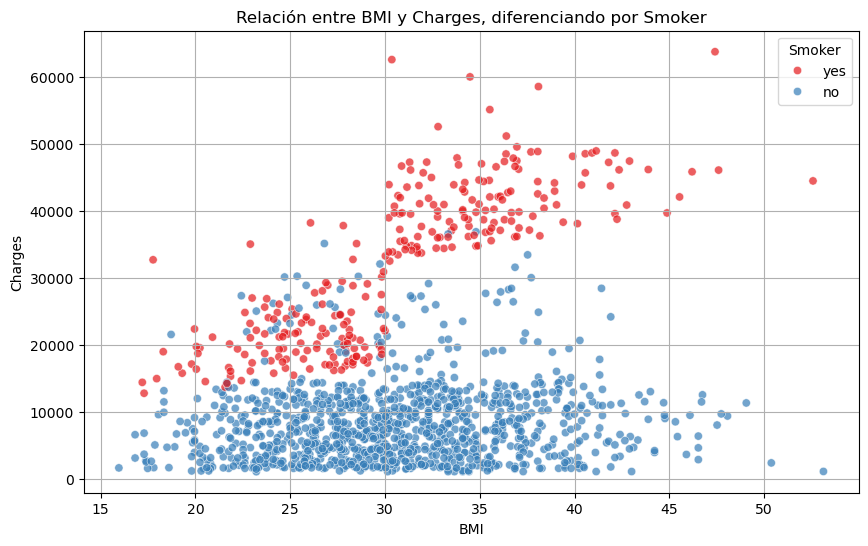

In [6]:
### grafico para verificacion de correlacion de variables con charges
# Scatter plot: bmi vs charges con color por smoker

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', alpha=0.7, palette='Set1')
plt.title('Relación entre BMI y Charges, diferenciando por Smoker')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(title='Smoker')
plt.grid(True)
plt.show()


##### Podemos ver en este grafico que BMI y smoker altos tienen una relacion positiva en un alto charge para su seguro medico, por lo que es una relacion interesante de analizarse.

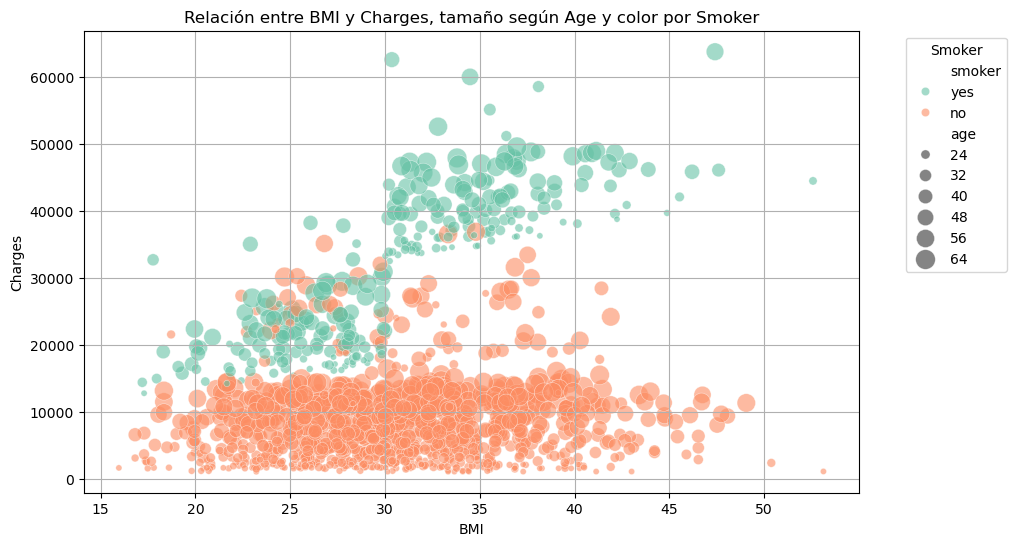

In [7]:
# Scatter plot: bmi vs charges, tamaño de los puntos según la edad

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='bmi', y='charges', size='age', hue='smoker', alpha=0.6, palette='Set2', sizes=(20, 200))
plt.title('Relación entre BMI y Charges, tamaño según Age y color por Smoker')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(title='Smoker', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

##### Al igual que el grafico anterior se ve una gran relacion entre el BMI y Smoker alto el relacion al precio, sin embargo a esto tambien se une la edad de los asegurados que a mayor edad y con estas variables, mayor el costo.

Text(0.5, 1.0, 'Matriz de Correlación Pearson')

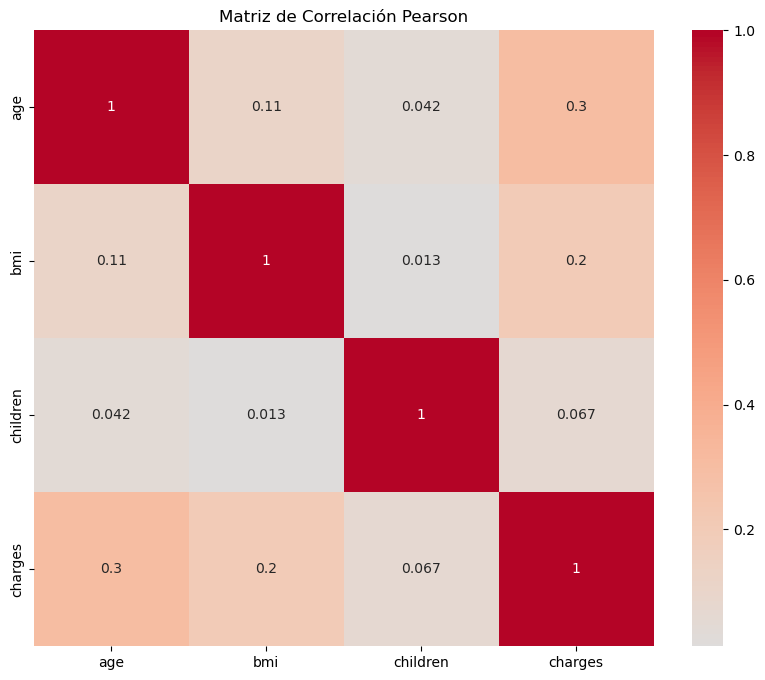

In [8]:
#### Grafico de correlacion de pearson entre variables numericas
variables_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_matrix = df[variables_numericas].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación Pearson')

#### En el grafico se puede observar que age y bmi son variables que pueden ser correlativas con el charges, sin embargo no representan una relacion fuerte con el target.

2. Preprocesamiento de Datos:

* Imputar valores faltantes utilizando técnicas adecuadas (media, mediana, moda, imputación avanzada).
* Codificar variables categóricas utilizando One-Hot Encoding.
* Escalar características numéricas utilizando StandardScaler.



In [9]:
# Crear una nueva columna 'charge_category' que clasifique 'charges' en low, medium, high
# Definir los percentiles para las categorías
bins = [0, df['charges'].quantile(0.33), df['charges'].quantile(0.66), df['charges'].max()]
labels = ['Low', 'Medium', 'High']
# Usar pd.cut para crear la nueva columna categórica
df['charge_category'] = pd.cut(df['charges'], bins=bins, labels=labels, include_lowest=True)

# Verificar los primeros valores para asegurarse de que la categorización es correcta
print(df[['charges', 'charge_category']].head())


       charges charge_category
0  16884.92400            High
1   1725.55230             Low
2   4449.46200             Low
3  21984.47061            High
4   3866.85520             Low


C:\Users\ENRIF\AppData\Local\Temp\ipykernel_8120\3796129793.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['charge_category'] = pd.cut(df['charges'], bins=bins, labels=labels, include_lowest=True)


In [10]:
# Definir X e y. Dividir los datos en conjunto de entrenamiento y prueba

X = df.drop(['charge_category'], axis=1)
y = df['charge_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [11]:
### No existen valores nulos que deban tratarse pero si valores outliers que seran escalados con RobustScaler ya que se encuentran valores outliers en BMI y charges
###Pipeline para preprocesamiento de valores
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Get column names
categorical_features = X.select_dtypes(include=['object']).columns.tolist() # Get column names
# Crear transformadores para cada subconjunto de columnas
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Crear transformer para columnas categóricas con imputación
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar categorías
])

# Combinar transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Integrar en un pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Crear y aplicar el pipeline a los datos de entrenamiento
X_train_transformed = pipeline.fit_transform(X_train)

# Aplicar la misma transformación a los datos de prueba (sin hacer fit)
X_test_transformed = pipeline.transform(X_test)

print("Preprocesamiento completado. Datos transformados listos para modelar.")

Preprocesamiento completado. Datos transformados listos para modelar.


Implementación de Modelos de Clasificación:

* Entrenar y evaluar al menos tres modelos de clasificación diferentes: Regresión Logística, K-Nearest Neighbors (KNN), y Árbol de Decisión.
* Utilizar validación cruzada para evaluar el rendimiento inicial de los modelos.



In [12]:
# Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Evaluación con validación cruzada
cv_results = {}
for model_name, model in models.items():
    # Validación cruzada con scoring de 'accuracy'
    scores = cross_val_score(model, X_train_transformed , y_train, cv=5, scoring='accuracy')
    cv_results[model_name] = scores
    print(f"{model_name}: Mean Accuracy = {scores.mean():.4f}, Std = {scores.std():.4f}")

# Comparar los resultados
import pandas as pd
cv_summary = pd.DataFrame(cv_results).T
cv_summary.columns = [f'Fold {i+1}' for i in range(cv_summary.shape[1])]
cv_summary['Mean Accuracy'] = cv_summary.mean(axis=1)
cv_summary['Std Dev'] = cv_summary.std(axis=1)
print("\nResumen de Validación Cruzada:")
print(cv_summary)


Logistic Regression: Mean Accuracy = 0.9551, Std = 0.0202
K-Nearest Neighbors: Mean Accuracy = 0.8765, Std = 0.0183
Decision Tree: Mean Accuracy = 0.9972, Std = 0.0038

Resumen de Validación Cruzada:
                       Fold 1    Fold 2    Fold 3    Fold 4    Fold 5  \
Logistic Regression  0.929907  0.971963  0.981308  0.934579  0.957746   
K-Nearest Neighbors  0.878505  0.892523  0.883178  0.841121  0.887324   
Decision Tree        0.995327  1.000000  1.000000  1.000000  0.990610   

                     Mean Accuracy   Std Dev  
Logistic Regression       0.955101  0.020169  
K-Nearest Neighbors       0.876530  0.018298  
Decision Tree             0.997187  0.003754  


##### De acuerdo a los resultados de la medicion inicial, decision tree tuvo mejor performance con acc de 0.99 y std de 0.0038 lo que quiere decir que las predicciones fueron extremadamente alta en cada particion de k-fold. Sin embargo el accuracy llega a casi 1 por lo que tendremos que ajustar el modelo para no generar overfitting 

Optimización de Hiperparámetros:

* Implementar GridSearchCV para optimizar los hiperparámetros de los modelos seleccionados.
* Implementar RandomizedSearchCV como método alternativo de optimización.
* Comparar los resultados de GridSearchCV y RandomizedSearchCV para los modelos optimizados.



In [ ]:
##Gridsearch
# Espacio de búsqueda para cada modelo
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200, 500]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

param_grid_dt = {
    'max_depth': [1, 3, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}


In [18]:
# Crear los modelos base
models = {
    'LogisticRegression': (LogisticRegression(random_state=42), param_grid_lr),
    'KNN': (KNeighborsClassifier(), param_grid_knn),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), param_grid_dt)
}

# Realizar GridSearchCV para cada modelo
grid_results = {}
for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_transformed, y_train)
    grid_results[name] = {
        'Best Params': grid_search.best_params_,
        'Best Score': grid_search.best_score_
    }

# Mostrar los resultados de GridSearchCV
import pandas as pd
grid_summary = pd.DataFrame(grid_results).T
print("Resultados de GridSearchCV:")
print(grid_summary)


Resultados de GridSearchCV:
                                                          Best Params  \
LogisticRegression     {'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}   
KNN                 {'metric': 'manhattan', 'n_neighbors': 5, 'wei...   
DecisionTree        {'criterion': 'gini', 'max_depth': 3, 'min_sam...   

                   Best Score  
LogisticRegression   0.972884  
KNN                  0.896165  
DecisionTree         0.997187  


In [33]:
###RandomizerSearch
# Espacio de búsqueda para RandomizedSearchCV
random_grid_lr = {
    'C': randint(1, 100),
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': randint(100, 500)
}

random_grid_knn = {
    'n_neighbors': randint(3, 10),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

random_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}

# Asociar los modelos con sus espacios de parámetros para RandomizedSearchCV
random_models = {
    'LogisticRegression': (LogisticRegression(random_state=42), random_grid_lr),
    'KNN': (KNeighborsClassifier(), random_grid_knn),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), random_grid_dt)
}

# Realizar RandomizedSearchCV para cada modelo
random_results = {}
for name, (model, random_grid) in random_models.items():
    random_search = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=50, 
                                    cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    random_search.fit(X_train_transformed, y_train)
    random_results[name] = random_search

# Crear DataFrame con los mejores resultados
results_data = {
    name: {
        'Best Params': random_search.best_params_,
        'Best Score': random_search.best_score_
    }
    for name, random_search in random_results.items()
}

results_df = pd.DataFrame(results_data).T
print(results_df)


                                                          Best Params  \
LogisticRegression      {'C': 72, 'max_iter': 288, 'solver': 'lbfgs'}   
KNN                 {'metric': 'manhattan', 'n_neighbors': 5, 'wei...   
DecisionTree        {'criterion': 'gini', 'max_depth': None, 'min_...   

                   Best Score  
LogisticRegression   0.974753  
KNN                  0.896165  
DecisionTree         0.997187  


In [35]:
###Comparar resultados
comparison = pd.concat([grid_summary['Best Score'], results_df['Best Score']], axis=1)
comparison.columns = ['GridSearchCV', 'RandomizedSearchCV']
print("Comparación de GridSearchCV y RandomizedSearchCV:")
print(comparison)

Comparación de GridSearchCV y RandomizedSearchCV:
                   GridSearchCV RandomizedSearchCV
LogisticRegression     0.972884           0.974753
KNN                    0.896165           0.896165
DecisionTree           0.997187           0.997187


### En ambos casos se ven que no hay una mejoria significativa, solo se ve que logisticRegression mejoro un poquito con RandomizedSearch

In [42]:
# Obtener los mejores modelos de RandomizedSearchCV
optimized_lr = random_results['LogisticRegression'].best_estimator_
optimized_knn = random_results['KNN'].best_estimator_
optimized_dt = random_results['DecisionTree'].best_estimator_

# Supongamos que ya tenemos los mejores modelos optimizados
best_models = {
    'LogisticRegression': optimized_lr,  # modelo entrenado
    'KNN': optimized_knn,                # modelo entrenado
    'DecisionTree': optimized_dt         # modelo entrenado
}


# Evaluación y almacenamiento de métricas
evaluation_results = {}

for name, model in best_models.items():
    y_pred = model.predict(X_test_transformed)
    y_pred_proba = model.predict_proba(X_test_transformed) if hasattr(model, "predict_proba") else None

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')  # 'macro' para multiclase
    recall = recall_score(y_test, y_pred, average='macro')        # 'macro' para multiclase
    f1 = f1_score(y_test, y_pred, average='macro')                # 'macro' para multiclase

    # Calcular ROC-AUC si aplica
    if y_pred_proba is not None:
        if y_pred_proba.ndim == 2:  # Salida bidimensional para multiclase
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # O 'ovo'
        else:
            roc_auc = "N/A"  # No se puede calcular ROC-AUC con una dimensión
    else:
        roc_auc = "N/A"

    # Almacenar resultados
    evaluation_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Convertir resultados a DataFrame para análisis
import pandas as pd
evaluation_df = pd.DataFrame(evaluation_results).T
print("Evaluación de Modelos:")
print(evaluation_df)


Evaluación de Modelos:
                    Accuracy  Precision    Recall  F1-Score   ROC-AUC
LogisticRegression  0.992537   0.992337  0.992509  0.992336  0.999872
KNN                 0.917910   0.917632  0.917633  0.917050  0.987614
DecisionTree        1.000000   1.000000  1.000000  1.000000  1.000000
